In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pickle
import os

# Create output directory if it doesn't exist
results_dir = 'prepared_processed_data'
os.makedirs(results_dir, exist_ok=True)

# 1. Load the dataset
print("Loading dataset...")
df = pd.read_csv('./processed_data/common_features.csv')

# 2. Basic exploration
print(f"Dataset shape: {df.shape}")
print(f"Missing values: {df.isna().sum().sum()}")

# 3. Check data types and identify non-numeric columns
print("\n=== DATA TYPE ANALYSIS ===")
print(df.dtypes.value_counts())

non_numeric_columns = df.select_dtypes(exclude=np.number).columns.tolist()
print(f"\nNon-numeric columns ({len(non_numeric_columns)}):")
for col in non_numeric_columns:
    unique_values = df[col].nunique()
    print(f"  - {col}: {df[col].dtype}, {unique_values} unique values")
    if unique_values < 10:  # Show examples if not too many
        print(f"    Values: {df[col].unique()}")

# 4. Handle non-numeric columns
print("\n=== HANDLING NON-NUMERIC COLUMNS ===")
# Identify columns to drop (identifiers) and columns to encode (categorical)
cols_to_drop = []
cols_to_encode = []

for col in non_numeric_columns:
    # Check if it's an identifier column
    if any(keyword in col.lower() for keyword in ['project', 'key', 'name', 'id', 'source', 'repository', 'file']):
        cols_to_drop.append(col)
    else:
        # Must be a categorical column
        cols_to_encode.append(col)

# Drop identifier columns
if cols_to_drop:
    print(f"Dropping identifier columns: {cols_to_drop}")
    df = df.drop(columns=cols_to_drop)

# Encode categorical variables
if cols_to_encode:
    print(f"Encoding categorical columns: {cols_to_encode}")
    # Use pandas get_dummies for one-hot encoding
    df = pd.get_dummies(df, columns=cols_to_encode, drop_first=True)
    print(f"Expanded to {df.shape[1]} columns after encoding")

# 5. Function for interquartile-based imputation and outlier capping
def impute_and_cap_using_iqr(df, columns=None, fill_missing=True, cap_outliers=True, iqr_multiplier=1.5):
    """
    Impute missing values and cap outliers using interquartile range method.
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe
    columns : list or None
        Columns to process. If None, will process all numeric columns.
    fill_missing : bool
        Whether to fill missing values with median
    cap_outliers : bool
        Whether to cap outliers based on IQR
    iqr_multiplier : float
        Multiplier for IQR to define outlier boundaries
        
    Returns:
    --------
    DataFrame
        Processed dataframe
    """
    df_clean = df.copy()
    
    if columns is None:
        columns = df.select_dtypes(include=np.number).columns
    
    for col in columns:
        # Skip if column doesn't exist
        if col not in df.columns:
            continue
            
        # Calculate quartiles and IQR
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        
        # Define lower and upper bounds
        lower_bound = q1 - iqr_multiplier * iqr
        upper_bound = q3 + iqr_multiplier * iqr
        
        # Fill missing values with median if requested
        if fill_missing and df[col].isna().sum() > 0:
            median_val = df[col].median()
            df_clean[col] = df_clean[col].fillna(median_val)
            print(f"Filled {df[col].isna().sum()} missing values in {col} with median: {median_val:.4f}")
        
        # Cap outliers if requested
        if cap_outliers:
            # Count outliers before capping
            n_lower_outliers = (df_clean[col] < lower_bound).sum()
            n_upper_outliers = (df_clean[col] > upper_bound).sum()
            
            if n_lower_outliers > 0 or n_upper_outliers > 0:
                # Apply capping
                df_clean[col] = df_clean[col].clip(lower=lower_bound, upper=upper_bound)
                print(f"Capped {n_lower_outliers} lower and {n_upper_outliers} upper outliers in {col}")
    
    return df_clean

# 6. Identify potential target variables
print("\n=== IDENTIFYING TARGET VARIABLES ===")
potential_target_variables = [
    'avg_resolution_hours',
    'median_resolution_hours',
    'min_resolution_hours',
    'max_resolution_hours',
    'resolution_hours_std',
    'total_resolution_hours'
]

# Check if all target variables exist
missing_targets = [var for var in potential_target_variables if var not in df.columns]
if missing_targets:
    print(f"Warning: Some target variables are missing: {missing_targets}")
    # Update the list to only include existing columns
    potential_target_variables = [var for var in potential_target_variables if var in df.columns]

print(f"Target variables: {potential_target_variables}")

# 7. Categorize features based on their type and expected distribution
print("\n=== CATEGORIZING FEATURES ===")

# Time-based features (excluding target variables)
time_features = [
    'resolution_time_p25', 
    'resolution_time_p75', 
    'resolution_time_p90', 
    'resolution_time_iqr', 
    'project_duration_days'
]

# Percentage features
pct_features = [
    'pct_resolved_within_24h', 'pct_resolved_within_week', 'pct_resolved_within_month',
    'pct_issues_created_on_weekend', 'pct_issues_resolved_on_weekend',
    'pct_resolved_issues', 'pct_issues_with_high_dependencies',
    'priority_critical_pct', 'priority_blocker_pct', 'type_bug_pct', 
    'type_task_pct', 'type_new_feature_pct', 'type_epic_pct', 
    'type_improvement_pct', 'type_story_pct', 'type_documentation_pct',
    'priority_high_pct', 'priority_low_pct'
]

# Count features
count_features = [
    'total_issues', 'max_issues_per_month', 'months_with_activity',
    'priority_critical_count', 'type_bug_count', 'type_task_count', 
    'type_new_feature_count', 'priority_critical_type_bug_count',
    'total_inward_links', 'total_outward_links', 'total_links',
    'num_resolved_issues', 'priority_blocker_count', 'type_epic_count',
    'priority_blocker_type_bug_count', 'type_improvement_count',
    'type_story_count', 'priority_high_count', 'priority_low_count',
    'type_documentation_count', 'priority_high_type_bug_count',
    'priority_low_type_bug_count'
]

# Statistical/rate features
stat_features = [
    'resolution_time_skewness', 'resolution_time_kurtosis',
    'avg_issues_per_month', 'issue_creation_volatility',
    'resolution_rate_per_day', 'type_task_resolution_rate', 
    'type_bug_resolution_rate', 'type_new_feature_resolution_rate',
    'weekly_efficiency_ratio', 'complexity_weighted_resolution_time',
    'high_to_low_priority_ratio', 'bug_ratio', 'creation_resolution_balance',
    'weighted_priority_score', 'issue_type_entropy', 'monthly_velocity',
    'type_epic_resolution_rate', 'type_story_resolution_rate',
    'type_improvement_resolution_rate', 'type_documentation_resolution_rate'
]

# Link-related features
link_features = [
    'avg_inward_links', 'avg_outward_links', 'avg_total_links',
    'link_density'
]

# Resolution hour features - these will be excluded from scaling as they're related to target variables
avg_resolution_features = [
    'priority_critical_type_bug_avg_resolution_hours',
    'priority_blocker_type_bug_avg_resolution_hours',
    'priority_high_type_bug_avg_resolution_hours',
    'priority_low_type_bug_avg_resolution_hours'
]

# Combine all feature categories
feature_categories = {
    'time_features': time_features,
    'pct_features': pct_features,
    'count_features': count_features,
    'stat_features': stat_features,
    'link_features': link_features,
    'avg_resolution_features': avg_resolution_features
}

# Filter to keep only features that exist in the dataframe
for category, features in feature_categories.items():
    filtered_features = [f for f in features if f in df.columns]
    if len(filtered_features) != len(features):
        print(f"Warning: Some features in {category} are missing from the dataset")
        print(f"  Missing: {set(features) - set(filtered_features)}")
    feature_categories[category] = filtered_features

# Get a flat list of all features being processed
all_features_to_process = []
for category, features in feature_categories.items():
    all_features_to_process.extend(features)

# 8. Apply interquartile-based imputation to all numeric features
print("\n=== APPLYING INTERQUARTILE-BASED IMPUTATION AND OUTLIER CAPPING ===")
numeric_columns = df.select_dtypes(include=np.number).columns.tolist()
df_clean = impute_and_cap_using_iqr(df, columns=numeric_columns, fill_missing=True, cap_outliers=True)

# 9. Separate features from targets
print("\n=== SEPARATING FEATURES FROM TARGETS ===")
# Include all columns except the target variables
feature_columns = [col for col in df_clean.columns if col not in potential_target_variables]
feature_df = df_clean[feature_columns]
target_df = df_clean[potential_target_variables]

# 10. Create the column transformer for feature scaling
print("\n=== CREATING FEATURE PREPROCESSING PIPELINE ===")
# Get the actual feature lists based on what's available in the dataframe
time_feats = feature_categories['time_features']
pct_feats = feature_categories['pct_features']
count_feats = feature_categories['count_features']
stat_feats = feature_categories['stat_features']
link_feats = feature_categories['link_features']

# Check if any feature categories are empty
for category, features in {'time': time_feats, 'pct': pct_feats, 'count': count_feats, 
                          'stat': stat_feats, 'link': link_feats}.items():
    if not features:
        print(f"Warning: No {category} features available for scaling")

# Create transformers only for non-empty feature lists
transformers = []
if time_feats:
    transformers.append(('time_power', PowerTransformer(method='yeo-johnson'), time_feats))
if pct_feats:
    transformers.append(('pct_minmax', MinMaxScaler(), pct_feats))
if count_feats:
    transformers.append(('count_std', StandardScaler(), count_feats))
if stat_feats:
    transformers.append(('stat_robust', RobustScaler(), stat_feats))
if link_feats:
    transformers.append(('link_std', StandardScaler(), link_feats))

feature_preprocessor = ColumnTransformer(
    transformers=transformers,
    remainder='passthrough'  # Non-numeric columns will pass through
)

# 11. Apply the preprocessing to features only
print("Scaling features (target variables will remain unchanged)...")
# Check if feature_df has any data
if feature_df.empty:
    print("Error: No features available for scaling!")
else:
    scaled_features = feature_preprocessor.fit_transform(feature_df)

    # 12. Create DataFrame with scaled features
    feature_names = feature_preprocessor.get_feature_names_out()
    df_scaled_features = pd.DataFrame(scaled_features, columns=feature_names, index=df_clean.index)

    # 13. Check if we've introduced any NaN values during scaling
    nan_count = df_scaled_features.isna().sum().sum()
    if nan_count > 0:
        print(f"Warning: {nan_count} NaN values introduced during scaling")
        # Replace NaNs with 0
        df_scaled_features = df_scaled_features.fillna(0)
        print("NaN values have been replaced with 0")

    # 14. Combine scaled features with original target variables
    final_df = pd.concat([df_scaled_features, target_df], axis=1)

    # 15. Save the results
    print("\n=== SAVING RESULTS ===")

    # Save the clean but unscaled dataset (after IQR imputation and outlier capping)
    df_clean.to_csv(f'{results_dir}/common_features_iqr_cleaned.csv', index=False)
    print("1. Saved cleaned dataset (after IQR processing): common_features_iqr_cleaned.csv")

    # Save the preprocessor for later use
    with open(f'{results_dir}/jira_feature_preprocessor.pkl', 'wb') as f:
        pickle.dump(feature_preprocessor, f)
    print("2. Saved feature preprocessor: jira_feature_preprocessor.pkl")

    # Save the dataset with scaled features and original target variables
    final_df.to_csv(f'{results_dir}/common_features_scaled_with_original_targets.csv', index=False)
    print("3. Saved scaled features with original targets: common_features_scaled_with_original_targets.csv")

    # 16. Print information about target variables (not scaled)
    print("\n=== TARGET VARIABLES (PRESERVED IN ORIGINAL UNITS) ===")
    for target in potential_target_variables:
        print(f"{target}: Mean = {df_clean[target].mean():.2f}, Median = {df_clean[target].median():.2f}, Min = {df_clean[target].min():.2f}, Max = {df_clean[target].max():.2f}")

print("\n=== PROCESSING COMPLETE ===")

In [11]:
import pandas as pd
import dtale

# Replace this path with the location of your CSV file
csv_file_path = "./prepared_processed_data/common_features_scaled_with_original_targets.csv"

# Read the CSV into a DataFrame
df = pd.read_csv(csv_file_path)

# Start a D-Tale session and open it in the browser
d = dtale.show(df, ignore_duplicate=True, allow_cell_edits=False)
d.open_browser()

Loading dataset...
Dataset shape: (971, 185)

=== DATASET OVERVIEW ===
Number of rows: 971
Number of columns: 185

=== MISSING VALUES IN KEY COLUMNS ===
total_resolution_hours    0
avg_resolution_hours      0
num_resolved_issues       0
total_issues              0
project_duration_days     0
dtype: int64

=== TARGET VARIABLE ANALYSIS ===
Target variable statistics:
count    9.710000e+02
mean     9.598742e+06
std      4.106977e+07
min      1.222222e-02
25%      1.444945e+05
50%      8.804546e+05
75%      4.839023e+06
max      6.046662e+08
Name: total_resolution_hours, dtype: float64

Skewness of target: 10.295072340968215
Skewness after log transformation: -1.1283067690134658
Kurtosis of target: 125.76711112948914
Kurtosis after log transformation: 2.434597077210513

Number of outliers: 136 (14.01%)

Correlation between calculated total and actual total: 1.000000

=== FEATURE CORRELATION ANALYSIS ===


/opt/anaconda3/envs/my_mongo_env/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning:

invalid value encountered in divide

/opt/anaconda3/envs/my_mongo_env/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning:

invalid value encountered in divide



Top 15 correlated features:
total_resolution_hours                 1.000000
calculated_total                       1.000000
priority_low_type_new_feature_count    0.992423
priority_low_type_improvement_count    0.991720
priority_normal_count                  0.980813
priority_low_type_bug_count            0.957417
priority_medium_type_task_count        0.950217
priority_low_count                     0.933593
priority_normal_type_bug_count         0.912708
priority_low_type_task_count           0.904320
priority_high_type_bug_count           0.871281
priority_minor_count                   0.817353
priority_major_type_bug_count          0.799335
priority_medium_type_bug_count         0.797027
priority_minor_type_bug_count          0.775337
dtype: float64

=== FEATURE CATEGORY ANALYSIS ===

=== MUTUAL INFORMATION ANALYSIS ===


/opt/anaconda3/envs/my_mongo_env/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning:

invalid value encountered in divide

/opt/anaconda3/envs/my_mongo_env/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning:

invalid value encountered in divide



ValueError: Input X contains NaN.

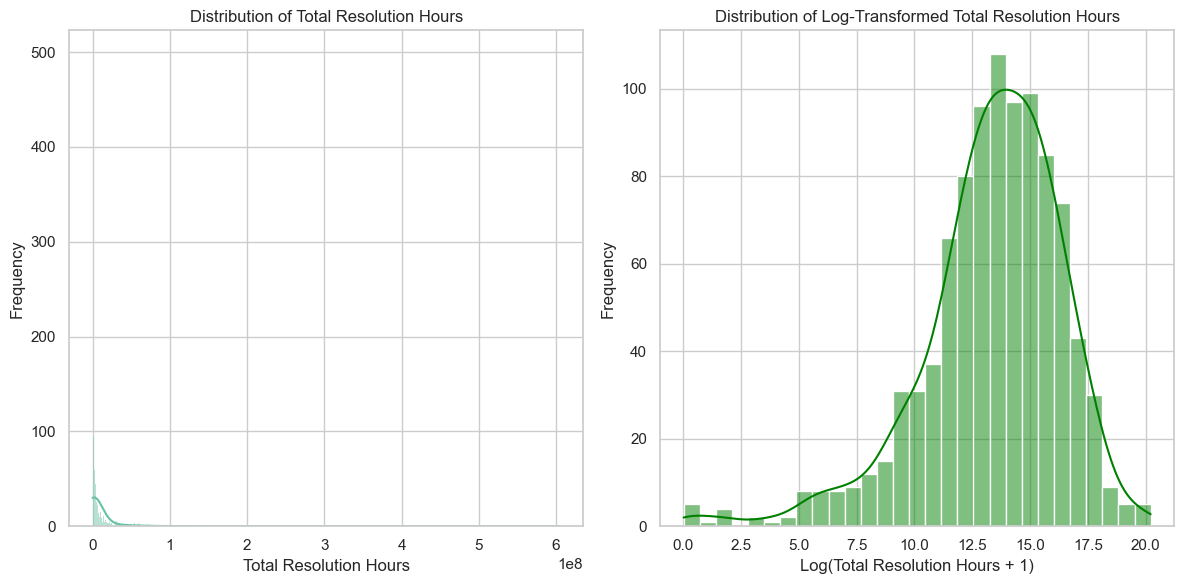

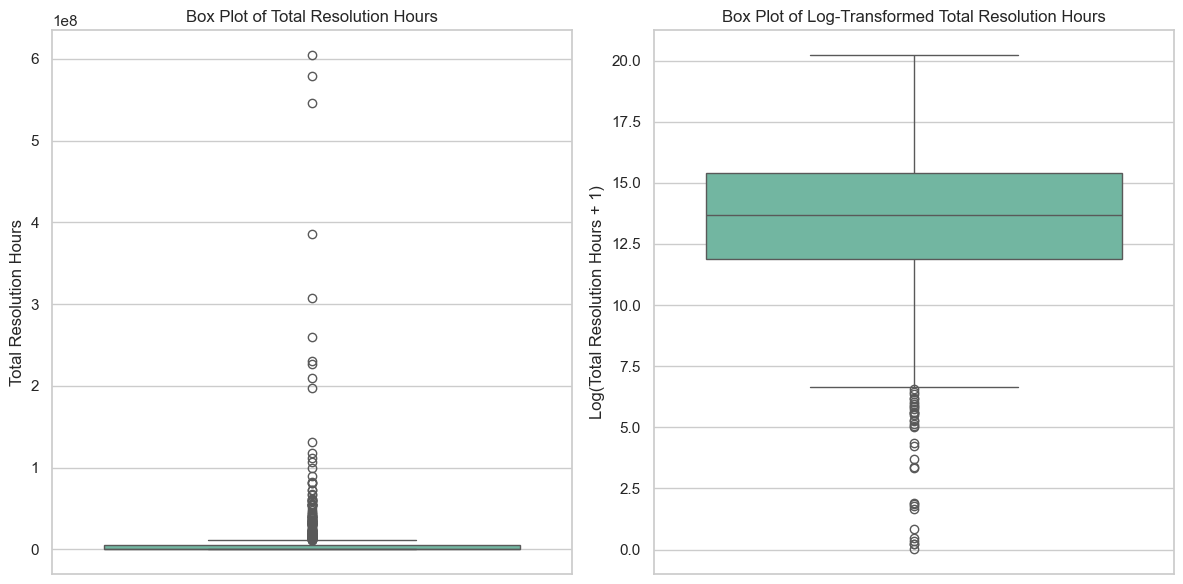

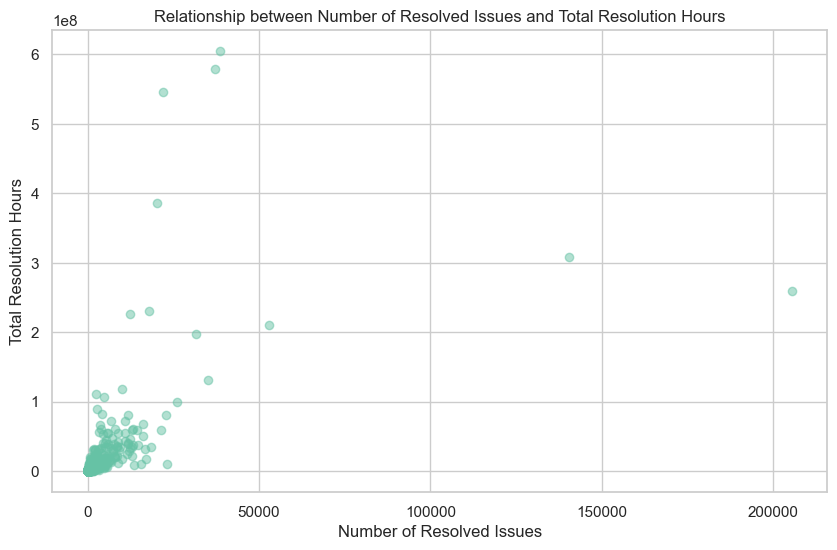

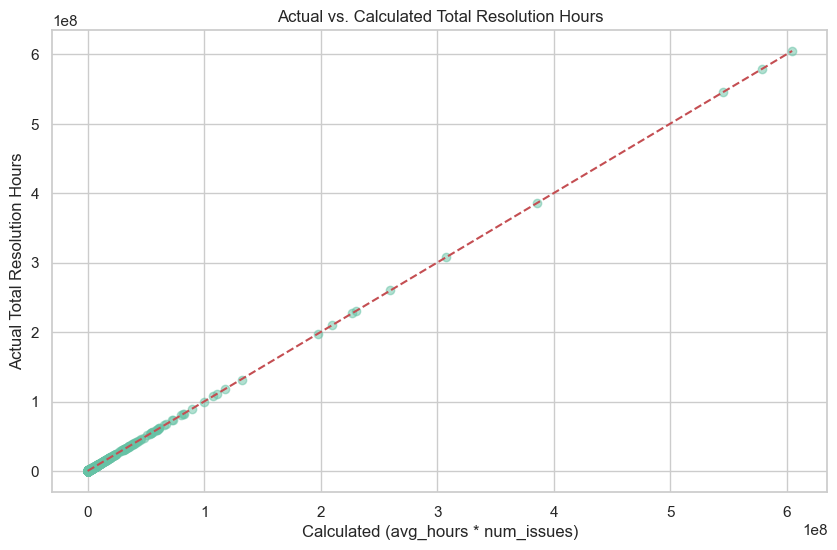

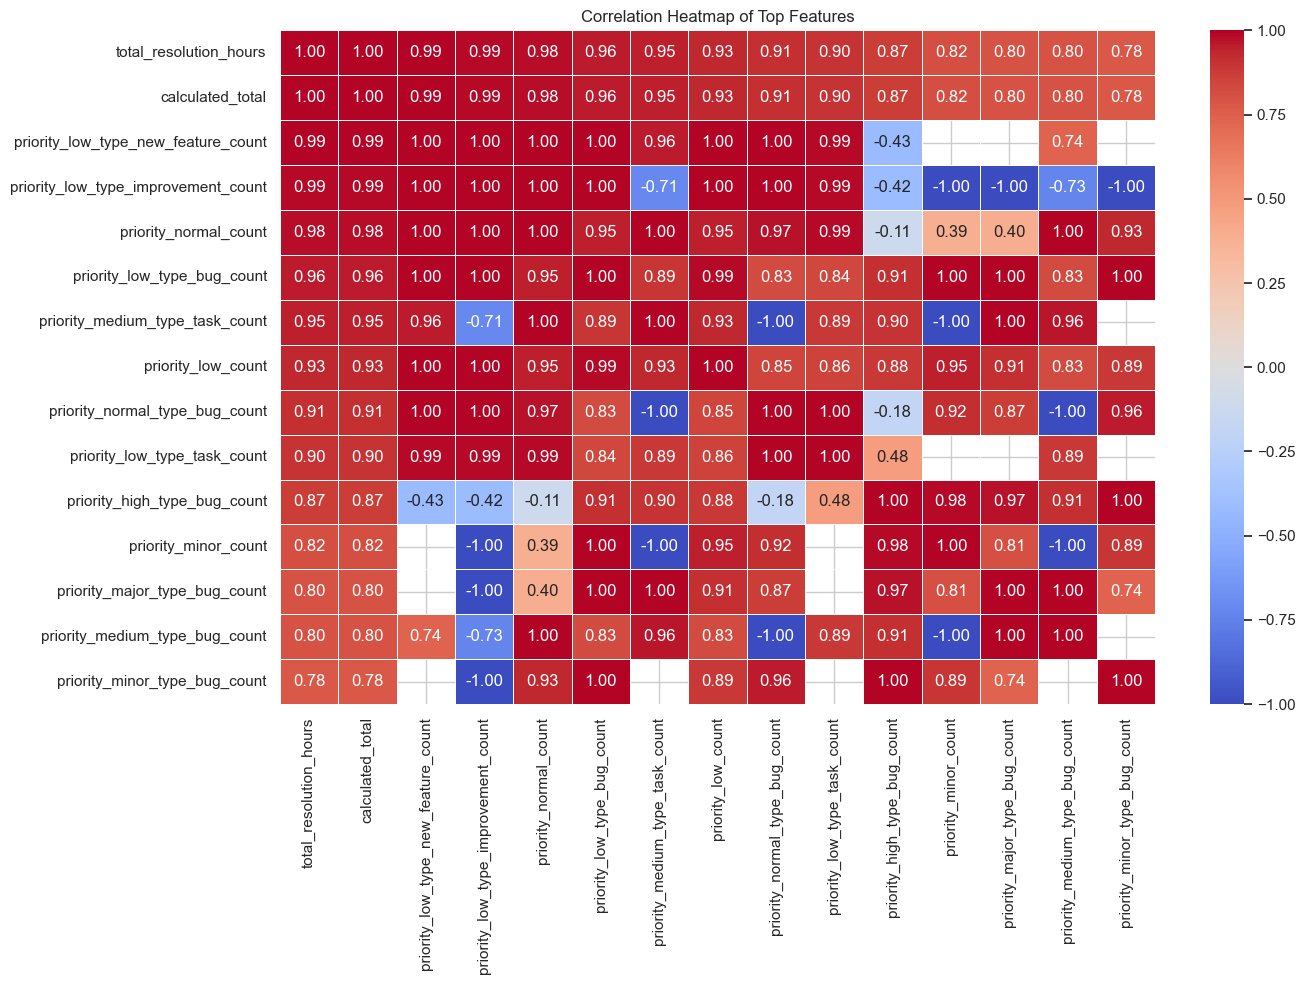

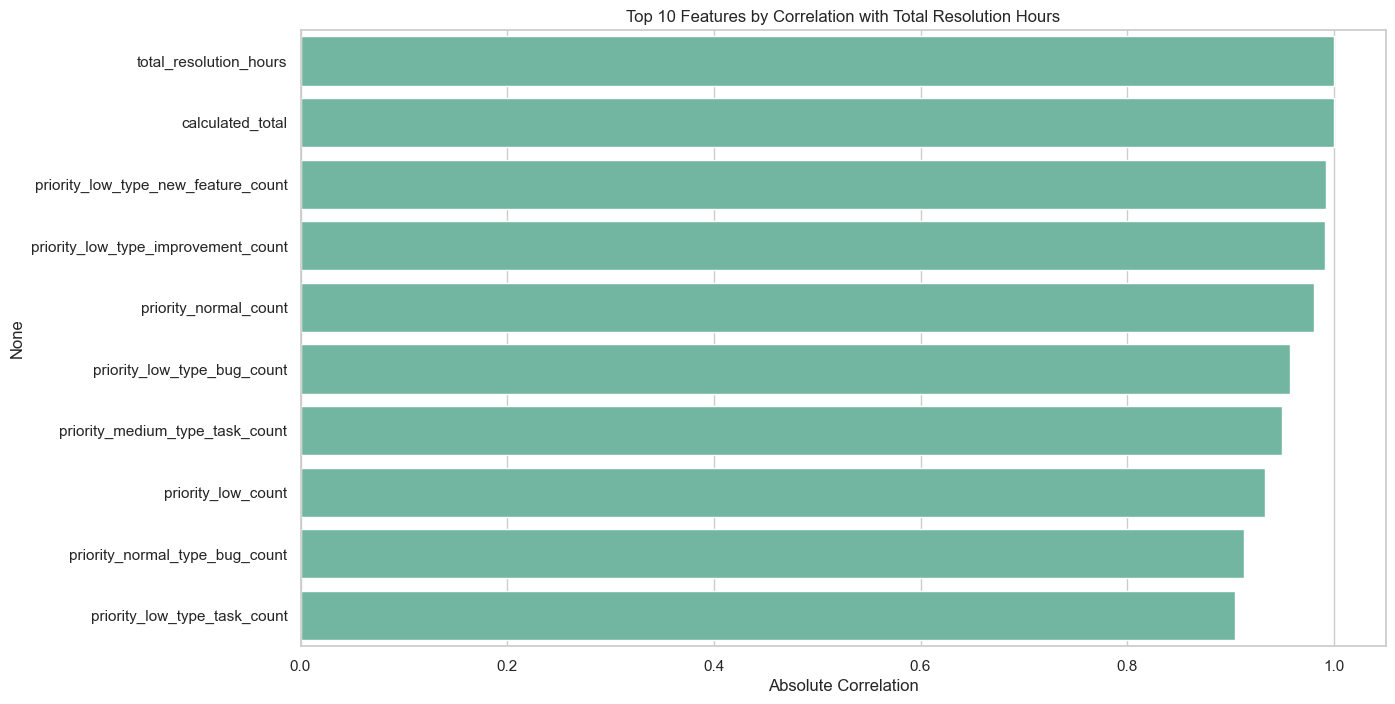

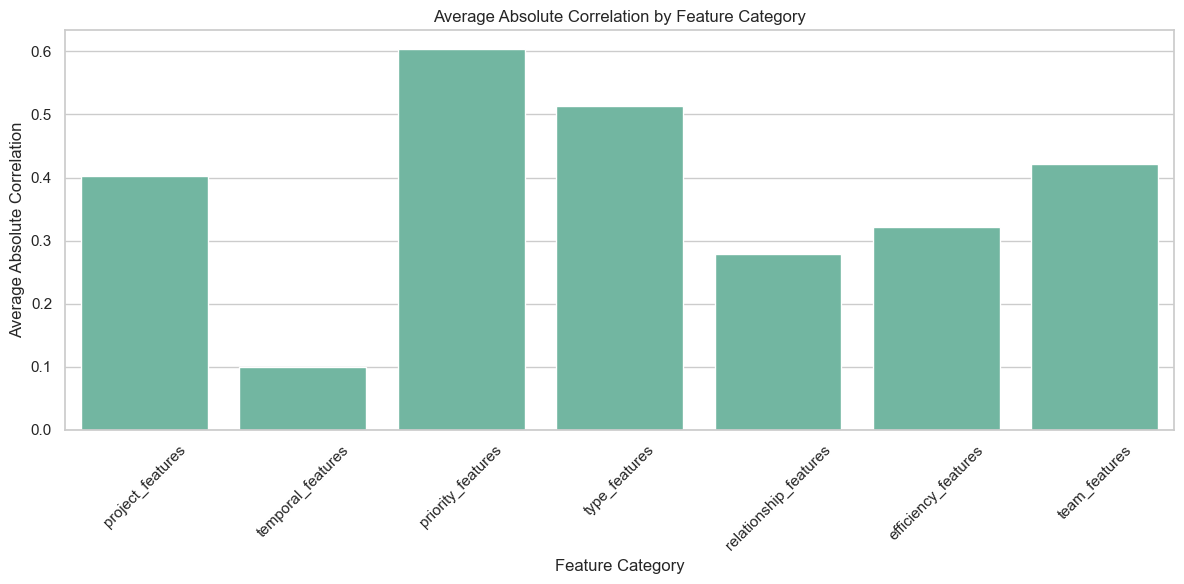

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
import os

# Create output directory for visualizations
viz_dir = 'visualizations'
os.makedirs(viz_dir, exist_ok=True)

# Set style for visualizations
plt.style.use('ggplot')
sns.set(style="whitegrid")
sns.set_palette("Set2")

# Load the dataset
print("Loading dataset...")
df = pd.read_csv('./processed_data/common_features.csv')
print(f"Dataset shape: {df.shape}")

# Basic info about the dataset
print("\n=== DATASET OVERVIEW ===")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

# Check for missing values in key columns
print("\n=== MISSING VALUES IN KEY COLUMNS ===")
key_columns = ['total_resolution_hours', 'avg_resolution_hours', 'num_resolved_issues', 
               'total_issues', 'project_duration_days']
missing_values = df[key_columns].isnull().sum()
print(missing_values)

# 1. Target Variable Analysis
print("\n=== TARGET VARIABLE ANALYSIS ===")
target = 'total_resolution_hours'

# Summary statistics for the target variable
target_stats = df[target].describe()
print(f"Target variable statistics:\n{target_stats}")

# Create distribution plot for total_resolution_hours
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df[target], kde=True)
plt.title('Distribution of Total Resolution Hours')
plt.xlabel('Total Resolution Hours')
plt.ylabel('Frequency')

# Create log-transformed version for comparison
plt.subplot(1, 2, 2)
log_target = np.log1p(df[target])  # log(1+x) to handle zero values
sns.histplot(log_target, kde=True, color='green')
plt.title('Distribution of Log-Transformed Total Resolution Hours')
plt.xlabel('Log(Total Resolution Hours + 1)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig(f'{viz_dir}/target_distribution.png')

# 2. Calculate skewness and kurtosis
print(f"\nSkewness of target: {df[target].skew()}")
print(f"Skewness after log transformation: {log_target.skew()}")
print(f"Kurtosis of target: {df[target].kurt()}")
print(f"Kurtosis after log transformation: {log_target.kurt()}")

# 3. Box plot for outlier detection
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y=df[target])
plt.title('Box Plot of Total Resolution Hours')
plt.ylabel('Total Resolution Hours')

plt.subplot(1, 2, 2)
sns.boxplot(y=log_target)
plt.title('Box Plot of Log-Transformed Total Resolution Hours')
plt.ylabel('Log(Total Resolution Hours + 1)')
plt.tight_layout()
plt.savefig(f'{viz_dir}/target_boxplots.png')

# 4. Identify outliers
Q1 = df[target].quantile(0.25)
Q3 = df[target].quantile(0.75)
IQR = Q3 - Q1
outlier_threshold = Q3 + 1.5 * IQR
outliers = df[df[target] > outlier_threshold]
print(f"\nNumber of outliers: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")

# 5. Examine the relationship between num_resolved_issues and total_resolution_hours
plt.figure(figsize=(10, 6))
plt.scatter(df['num_resolved_issues'], df[target], alpha=0.5)
plt.title('Relationship between Number of Resolved Issues and Total Resolution Hours')
plt.xlabel('Number of Resolved Issues')
plt.ylabel('Total Resolution Hours')
plt.savefig(f'{viz_dir}/resolved_vs_total_hours.png')

# 6. Check if avg_resolution_hours * num_resolved_issues ≈ total_resolution_hours
df['calculated_total'] = df['avg_resolution_hours'] * df['num_resolved_issues']
print(f"\nCorrelation between calculated total and actual total: {df['calculated_total'].corr(df[target]):.6f}")

plt.figure(figsize=(10, 6))
plt.scatter(df['calculated_total'], df[target], alpha=0.5)
plt.title('Actual vs. Calculated Total Resolution Hours')
plt.xlabel('Calculated (avg_hours * num_issues)')
plt.ylabel('Actual Total Resolution Hours')
plt.plot([df[target].min(), df[target].max()], [df[target].min(), df[target].max()], 'r--')
plt.savefig(f'{viz_dir}/actual_vs_calculated.png')

# 7. Feature Correlation Analysis
print("\n=== FEATURE CORRELATION ANALYSIS ===")

# Select numeric columns only
numeric_df = df.select_dtypes(include=[np.number])

# Calculate correlation with target
correlations = numeric_df.corrwith(df[target]).sort_values(ascending=False)
top_correlations = correlations.abs().sort_values(ascending=False).head(15)
print("Top 15 correlated features:")
print(top_correlations)

# Create correlation heatmap with top features
top_feature_names = top_correlations.index.tolist()
plt.figure(figsize=(14, 10))
correlation_matrix = numeric_df[top_feature_names].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Top Features')
plt.tight_layout()
plt.savefig(f'{viz_dir}/correlation_heatmap.png')

# 8. Create a bar chart for top correlated features
plt.figure(figsize=(14, 8))
top_10_correlations = correlations.abs().sort_values(ascending=False).head(10)
sns.barplot(x=top_10_correlations.values, y=top_10_correlations.index)
plt.title('Top 10 Features by Correlation with Total Resolution Hours')
plt.xlabel('Absolute Correlation')
plt.savefig(f'{viz_dir}/top_correlations.png')

# 9. Analyze feature categories
print("\n=== FEATURE CATEGORY ANALYSIS ===")
feature_categories = {
    'project_features': ['total_issues', 'project_duration_days', 'months_with_activity'],
    'temporal_features': ['pct_resolved_within_24h', 'pct_resolved_within_week', 'pct_resolved_within_month'],
    'priority_features': [col for col in df.columns if 'priority_' in col and '_count' in col],
    'type_features': [col for col in df.columns if 'type_' in col and '_count' in col],
    'relationship_features': ['avg_inward_links', 'avg_outward_links', 'total_links', 'link_density'],
    'efficiency_features': ['resolution_rate_per_day', 'weekly_efficiency_ratio', 'monthly_velocity'],
    'team_features': ['team_size_creators', 'team_size_assignees', 'team_size_combined']
}

# Calculate average correlation by feature category
category_correlations = {}
for category, features in feature_categories.items():
    # Filter to only include features that exist in the dataframe
    valid_features = [f for f in features if f in df.columns]
    if valid_features:
        # Calculate the average absolute correlation
        category_corr = np.mean([abs(df[f].corr(df[target])) for f in valid_features if not pd.isna(df[f].corr(df[target]))])
        category_correlations[category] = category_corr
    else:
        category_correlations[category] = 0

# Create a bar chart for category correlations
plt.figure(figsize=(12, 6))
categories = list(category_correlations.keys())
corr_values = list(category_correlations.values())
sns.barplot(x=categories, y=corr_values)
plt.title('Average Absolute Correlation by Feature Category')
plt.xlabel('Feature Category')
plt.ylabel('Average Absolute Correlation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'{viz_dir}/category_correlations.png')

# 10. Mutual Information for detecting non-linear relationships
print("\n=== MUTUAL INFORMATION ANALYSIS ===")
# Select features (exclude the target and other resolution hour features)
resolution_hour_columns = [col for col in df.columns if 'resolution_hours' in col]
X = numeric_df.drop(columns=resolution_hour_columns + ['calculated_total'])

# Calculate mutual information
mi_scores = mutual_info_regression(X, df[target])
mi_df = pd.DataFrame({'Feature': X.columns, 'MI Score': mi_scores})
mi_df = mi_df.sort_values('MI Score', ascending=False)
print("Top 10 features by Mutual Information:")
print(mi_df.head(10))

# Create a bar chart for top mutual information scores
plt.figure(figsize=(14, 8))
top_10_mi = mi_df.head(10)
sns.barplot(x=top_10_mi['MI Score'], y=top_10_mi['Feature'])
plt.title('Top 10 Features by Mutual Information with Total Resolution Hours')
plt.xlabel('Mutual Information Score')
plt.tight_layout()
plt.savefig(f'{viz_dir}/mutual_information.png')

# 11. Scatter plots for key relationships
plt.figure(figsize=(16, 12))

# Select top 6 correlated features that aren't direct calculations
top_features = [f for f in correlations.abs().sort_values(ascending=False).index.tolist() 
               if f != 'calculated_total' and 'resolution_hours' not in f][:6]

for i, feature in enumerate(top_features):
    plt.subplot(2, 3, i+1)
    plt.scatter(df[feature], np.log1p(df[target]), alpha=0.5)
    plt.title(f'{feature} vs log(Total Resolution Hours)')
    plt.xlabel(feature)
    plt.ylabel('log(Total Resolution Hours + 1)')

plt.tight_layout()
plt.savefig(f'{viz_dir}/key_relationships.png')

# 12. Project type analysis - how resolution hours vary by issue type distribution
plt.figure(figsize=(16, 6))

# Create a scatter plot showing how bug ratio affects resolution hours
plt.subplot(1, 2, 1)
plt.scatter(df['bug_ratio'], np.log1p(df[target]), alpha=0.5)
plt.title('Bug Ratio vs Total Resolution Hours')
plt.xlabel('Bug Ratio')
plt.ylabel('log(Total Resolution Hours + 1)')

# Create a scatter plot for issue type entropy
plt.subplot(1, 2, 2)
plt.scatter(df['issue_type_entropy'], np.log1p(df[target]), alpha=0.5)
plt.title('Issue Type Entropy vs Total Resolution Hours')
plt.xlabel('Issue Type Entropy')
plt.ylabel('log(Total Resolution Hours + 1)')

plt.tight_layout()
plt.savefig(f'{viz_dir}/project_type_analysis.png')

# 13. Temporal patterns
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.scatter(df['project_duration_days'], np.log1p(df[target]), alpha=0.5)
plt.title('Project Duration vs Total Resolution Hours')
plt.xlabel('Project Duration (days)')
plt.ylabel('log(Total Resolution Hours + 1)')

plt.subplot(1, 2, 2)
plt.scatter(df['resolution_rate_per_day'], np.log1p(df[target]), alpha=0.5)
plt.title('Resolution Rate vs Total Resolution Hours')
plt.xlabel('Resolution Rate per Day')
plt.ylabel('log(Total Resolution Hours + 1)')

plt.tight_layout()
plt.savefig(f'{viz_dir}/temporal_patterns.png')

# 14. Team factors impact
if all(col in df.columns for col in ['team_size_combined', 'team_complexity_capacity']):
    plt.figure(figsize=(16, 6))
    
    plt.subplot(1, 2, 1)
    plt.scatter(df['team_size_combined'], np.log1p(df[target]), alpha=0.5)
    plt.title('Team Size vs Total Resolution Hours')
    plt.xlabel('Team Size (Combined)')
    plt.ylabel('log(Total Resolution Hours + 1)')
    
    plt.subplot(1, 2, 2)
    plt.scatter(df['team_complexity_capacity'], np.log1p(df[target]), alpha=0.5)
    plt.title('Team Complexity Capacity vs Total Resolution Hours')
    plt.xlabel('Team Complexity Capacity')
    plt.ylabel('log(Total Resolution Hours + 1)')
    
    plt.tight_layout()
    plt.savefig(f'{viz_dir}/team_factors.png')

# 15. Priority distribution impact
plt.figure(figsize=(14, 10))

priority_columns = [col for col in df.columns if 'priority_' in col and '_pct' in col][:6]
for i, feature in enumerate(priority_columns):
    if feature in df.columns:
        plt.subplot(2, 3, i+1)
        plt.scatter(df[feature], np.log1p(df[target]), alpha=0.5)
        plt.title(f'{feature} vs Total Resolution Hours')
        plt.xlabel(feature)
        plt.ylabel('log(Total Resolution Hours + 1)')

plt.tight_layout()
plt.savefig(f'{viz_dir}/priority_impact.png')

print(f"\nVisualizations saved to {viz_dir}/")
print("\nAnalysis complete!")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import os

# Create output directory for visualizations
viz_dir = 'resolution_hours_analysis'
os.makedirs(viz_dir, exist_ok=True)

# Set visualization style
plt.style.use('ggplot')
sns.set_style("whitegrid")
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

print("Loading dataset...")
df = pd.read_csv('./processed_data/common_features.csv')
print(f"Dataset shape: {df.shape}")

# --------------------------------------------------
# 1. TARGET VARIABLE VISUALIZATION
# --------------------------------------------------
target = 'total_resolution_hours'
df['log_total_resolution_hours'] = np.log1p(df[target])

# Create distribution plots
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.histplot(df[target], kde=True, color='steelblue')
plt.title('Distribution of Total Resolution Hours', fontsize=14)
plt.xlabel('Total Resolution Hours', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

plt.subplot(1, 2, 2)
sns.histplot(df['log_total_resolution_hours'], kde=True, color='forestgreen')
plt.title('Distribution of Log-Transformed Total Resolution Hours', fontsize=14)
plt.xlabel('Log(Total Resolution Hours + 1)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.savefig(f'{viz_dir}/target_distribution.png', dpi=300)
plt.close()

# Create boxplots
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.boxplot(y=df[target], color='steelblue')
plt.title('Boxplot of Total Resolution Hours', fontsize=14)
plt.ylabel('Total Resolution Hours', fontsize=12)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.subplot(1, 2, 2)
sns.boxplot(y=df['log_total_resolution_hours'], color='forestgreen')
plt.title('Boxplot of Log-Transformed Total Resolution Hours', fontsize=14)
plt.ylabel('Log(Total Resolution Hours + 1)', fontsize=12)

plt.tight_layout()
plt.savefig(f'{viz_dir}/target_boxplots.png', dpi=300)
plt.close()

# --------------------------------------------------
# 2. PLANNING-TIME FEATURES ANALYSIS
# --------------------------------------------------

# Define features available at planning time
planning_features = [
    # Project scope indicators
    'total_issues',                    # Estimated during planning
    
    # Project composition estimates
    'priority_critical_pct',           # Expected critical issues
    'priority_high_pct',               # Expected high priority issues
    'priority_medium_pct',             # Expected medium priority issues
    'priority_low_pct',                # Expected low priority issues
    'priority_blocker_pct',            # Expected blocker issues
    
    # Issue type distribution (estimated from similar projects)
    'type_bug_pct',                    # Expected bug percentage
    'type_task_pct',                   # Expected task percentage
    'type_new_feature_pct',            # Expected feature work
    'type_improvement_pct',            # Expected improvements
    'type_documentation_pct',          # Expected documentation work
    
    # Team composition
    'team_size_creators',              # Planned team size
    'team_size_assignees',             # Planned assignees
    'team_size_combined',              # Overall team size
    
    # Complexity indicators
    'weighted_priority_score',         # Expected priority complexity
    'issue_type_entropy',              # Expected variety of issues
    
    # Historical indicators that could be estimated
    'high_to_low_priority_ratio',      # Expected priority distribution
    'bug_ratio',                       # Expected bug ratio
]

# Filter to features that exist in the dataframe
planning_features = [f for f in planning_features if f in df.columns]

# Create a correlation matrix of planning features with the target
planning_correlations = df[planning_features].corrwith(df['log_total_resolution_hours'])
planning_correlations = planning_correlations.sort_values(ascending=False)

# Visualize correlations
plt.figure(figsize=(12, 10))
sns.barplot(x=planning_correlations.values, y=planning_correlations.index, palette='viridis')
plt.title('Planning-Time Features: Correlation with Log-Transformed Resolution Hours', fontsize=14)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(f'{viz_dir}/planning_feature_correlations.png', dpi=300)
plt.close()

# Create scatter plots for top features
top_features = planning_correlations.abs().sort_values(ascending=False).head(6).index

plt.figure(figsize=(18, 12))
for i, feature in enumerate(top_features):
    plt.subplot(2, 3, i+1)
    
    # Filter out NaN values
    valid_data = df[[feature, 'log_total_resolution_hours']].dropna()
    
    # Create scatter plot
    sns.regplot(x=feature, y='log_total_resolution_hours', data=valid_data, 
               scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    
    # Calculate correlation
    corr = valid_data[feature].corr(valid_data['log_total_resolution_hours'])
    
    plt.title(f'{feature} vs. Log-Transformed Resolution Hours', fontsize=12)
    plt.xlabel(feature, fontsize=10)
    plt.ylabel('Log(Total Resolution Hours + 1)', fontsize=10)
    plt.annotate(f'r = {corr:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', 
                fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{viz_dir}/top_feature_relationships.png', dpi=300)
plt.close()

# --------------------------------------------------
# 3. FEATURE CATEGORY ANALYSIS
# --------------------------------------------------

# Group features by category
feature_categories = {
    'Project Scope': ['total_issues', 'project_duration_days'],
    'Priority Distribution': [col for col in planning_features if 'priority_' in col and '_pct' in col],
    'Issue Types': [col for col in planning_features if 'type_' in col and '_pct' in col],
    'Team Composition': [col for col in planning_features if 'team_' in col],
    'Complexity Metrics': ['weighted_priority_score', 'issue_type_entropy', 'high_to_low_priority_ratio', 'bug_ratio']
}

# Calculate average correlation by category
category_correlations = {}
for category, features in feature_categories.items():
    # Get features that exist in the dataframe
    existing_features = [f for f in features if f in df.columns]
    if existing_features:
        # Get absolute correlations
        abs_corrs = df[existing_features].corrwith(df['log_total_resolution_hours']).abs()
        category_correlations[category] = abs_corrs.mean()

# Visualize category correlations
plt.figure(figsize=(12, 6))
categories = list(category_correlations.keys())
correlations = list(category_correlations.values())

# Sort by correlation
sorted_indices = np.argsort(correlations)[::-1]
categories = [categories[i] for i in sorted_indices]
correlations = [correlations[i] for i in sorted_indices]

sns.barplot(x=categories, y=correlations, palette='viridis')
plt.title('Average Correlation by Feature Category', fontsize=14)
plt.xlabel('Feature Category', fontsize=12)
plt.ylabel('Average Absolute Correlation', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(f'{viz_dir}/category_correlations.png', dpi=300)
plt.close()

# --------------------------------------------------
# 4. PRIORITY & ISSUE TYPE IMPACT VISUALIZATION
# --------------------------------------------------

# Create visualizations for priority distribution impact
priority_features = [col for col in df.columns if 'priority_' in col and '_pct' in col]
priority_features = [f for f in priority_features if f in df.columns][:5]  # Limit to top 5

if priority_features:
    plt.figure(figsize=(18, 6))
    for i, feature in enumerate(priority_features):
        plt.subplot(1, 5, i+1)
        valid_data = df[[feature, 'log_total_resolution_hours']].dropna()
        
        sns.regplot(x=feature, y='log_total_resolution_hours', data=valid_data, 
                   scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
        
        plt.title(f'Impact of {feature}', fontsize=12)
        plt.xlabel(feature, fontsize=10)
        plt.ylabel('Log(Total Hours)' if i == 0 else '', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(f'{viz_dir}/priority_impact.png', dpi=300)
    plt.close()

# Create visualizations for issue type impact
issue_type_features = [col for col in df.columns if 'type_' in col and '_pct' in col]
issue_type_features = [f for f in issue_type_features if f in df.columns][:5]  # Limit to top 5

if issue_type_features:
    plt.figure(figsize=(18, 6))
    for i, feature in enumerate(issue_type_features):
        plt.subplot(1, 5, i+1)
        valid_data = df[[feature, 'log_total_resolution_hours']].dropna()
        
        sns.regplot(x=feature, y='log_total_resolution_hours', data=valid_data, 
                   scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
        
        plt.title(f'Impact of {feature}', fontsize=12)
        plt.xlabel(feature, fontsize=10)
        plt.ylabel('Log(Total Hours)' if i == 0 else '', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(f'{viz_dir}/issue_type_impact.png', dpi=300)
    plt.close()

# --------------------------------------------------
# 5. MODEL TRAINING & FEATURE IMPORTANCE
# --------------------------------------------------

# Prepare the data for modeling
df_planning = df[planning_features + ['log_total_resolution_hours']].copy()

# Handle missing values with imputation
imputer = SimpleImputer(strategy='median')
df_planning[planning_features] = imputer.fit_transform(df_planning[planning_features])

# Check for and replace infinite values
for col in planning_features:
    mask = np.isinf(df_planning[col])
    if mask.any():
        print(f"Replacing {mask.sum()} infinite values in {col}")
        df_planning.loc[mask, col] = df_planning[col].median()

# Split data into features and target
X = df_planning[planning_features]
y = df_planning['log_total_resolution_hours']

# Scale features
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
rf_pred = rf_model.predict(X_test)

# Evaluate model
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)

print(f"Random Forest - RMSE: {rf_rmse:.4f}, R²: {rf_r2:.4f}")

# Get feature importances
feature_importances = pd.DataFrame({
    'Feature': planning_features,
    'Importance': rf_model.feature_importances_
})
feature_importances = feature_importances.sort_values('Importance', ascending=False)

# Visualize feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')
plt.title('Feature Importance for Predicting Resolution Hours', fontsize=14)
plt.xlabel('Importance Score', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(f'{viz_dir}/feature_importance.png', dpi=300)
plt.close()

# --------------------------------------------------
# 6. ACTUAL VS PREDICTED VISUALIZATION
# --------------------------------------------------

# Create scatter plot of actual vs predicted
plt.figure(figsize=(14, 7))

# Log scale comparison
plt.subplot(1, 2, 1)
plt.scatter(y_test, rf_pred, alpha=0.6, c='steelblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs Predicted: Log Scale', fontsize=14)
plt.xlabel('Actual Log(Total Resolution Hours)', fontsize=12)
plt.ylabel('Predicted Log(Total Resolution Hours)', fontsize=12)
plt.annotate(f'R² = {rf_r2:.4f}', xy=(0.05, 0.95), xycoords='axes fraction', 
            fontsize=12, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)

# Original scale comparison 
plt.subplot(1, 2, 2)
y_test_original = np.expm1(y_test)
rf_pred_original = np.expm1(rf_pred)

plt.scatter(y_test_original, rf_pred_original, alpha=0.6, c='forestgreen')
plt.title('Actual vs Predicted: Original Scale', fontsize=14)
plt.xlabel('Actual Total Resolution Hours', fontsize=12) 
plt.ylabel('Predicted Total Resolution Hours', fontsize=12)
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
plt.grid(True, linestyle='--', alpha=0.7)

# Draw reference line
max_val = max(y_test_original.max(), rf_pred_original.max())
plt.plot([0, max_val], [0, max_val], 'r--')

plt.tight_layout()
plt.savefig(f'{viz_dir}/actual_vs_predicted.png', dpi=300)
plt.close()

# --------------------------------------------------
# 7. ERROR ANALYSIS
# --------------------------------------------------

# Calculate prediction errors
errors = y_test - rf_pred
abs_errors = np.abs(errors)

# Create error distribution plot
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.histplot(errors, kde=True, color='steelblue')
plt.title('Distribution of Prediction Errors (Log Scale)', fontsize=14)
plt.xlabel('Prediction Error', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=abs_errors, alpha=0.6, color='forestgreen')
plt.title('Error Magnitude vs Actual Value', fontsize=14)
plt.xlabel('Actual Log(Total Resolution Hours)', fontsize=12)
plt.ylabel('Absolute Error', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig(f'{viz_dir}/error_analysis.png', dpi=300)
plt.close()

# --------------------------------------------------
# 8. SUMMARY HEATMAP
# --------------------------------------------------

# Create a correlation heatmap of top planning features
top_planning_features = feature_importances.head(10)['Feature'].tolist()
correlation_matrix = df[top_planning_features + ['log_total_resolution_hours']].corr()

plt.figure(figsize=(14, 12))
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt='.2f', 
           linewidths=0.5, mask=mask)
plt.title('Correlation Matrix of Top Planning Features', fontsize=16)
plt.tight_layout()
plt.savefig(f'{viz_dir}/correlation_heatmap.png', dpi=300)
plt.close()

print(f"\nAnalysis complete! All visualizations saved to {viz_dir}/")

Loading dataset...
Dataset shape: (971, 185)


/opt/anaconda3/envs/my_mongo_env/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning:

invalid value encountered in divide

/opt/anaconda3/envs/my_mongo_env/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning:

invalid value encountered in divide

/var/folders/lt/2k0m0j2d6xqg0wz_673wgqt00000gn/T/ipykernel_72786/1243093028.py:119: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/opt/anaconda3/envs/my_mongo_env/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning:

invalid value encountered in divide

/opt/anaconda3/envs/my_mongo_env/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning:

invalid value encountered in divide

/var/folders/lt/2k0m0j2d6xqg0wz_673wgqt00000gn/T/ipykernel_72786/1243093028.py:187: FutureWarning:



Passing `pale

Random Forest - RMSE: 1.0818, R²: 0.8602


/var/folders/lt/2k0m0j2d6xqg0wz_673wgqt00000gn/T/ipykernel_72786/1243093028.py:294: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.





Analysis complete! All visualizations saved to resolution_hours_analysis/
